In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import pyemma
import mdtraj
import pyemma.util.contexts
import pickle
from pathos.multiprocessing import Pool
from contextlib import closing

## Estimation

In [4]:
# load data from disk
topfile_0cal = 'hsynapto.pdb'
trajfiles_aligned = np.loadtxt('trajfile_list.txt', dtype=str).tolist()

# reference mdtraj trajectory object
ref_0cal = mdtraj.load_pdb(topfile_0cal)

In [5]:
first_resid = 5  # truncate n and c-terminal residues
system_integers = np.arange(first_resid, ref_0cal.top.n_residues - 2 * first_resid)

In [8]:
# compute feature vector for each residue and store in a dictionary
res_heavyatomxyzs = dict()

with pyemma.util.contexts.settings(show_progress_bars=False):
    for n in tqdm(system_integers):
        f = pyemma.coordinates.featurizer(topfile_0cal)
        f.add_selection(f.select(f'mass > 2 and resid {n}'))
        res_heavyatomxyzs[n] = pyemma.coordinates.load(trajfiles_aligned, features=f)

In [72]:
# save or load from disc to increase efficiency
# pickle.dump(res_heavyatomxyzs, open('res_heavyatomxyz.pickle', 'wb'))
res_heavyatomxyzs = pickle.load(open('res_heavyatomxyz.pickle', 'rb'))

In [6]:
# choose lag time for vamp computation (in ns)
msmlag = 50

In [8]:
# all pairwise combinations of residue indices
args = list(itertools.combinations(system_integers, 2))

def get_edge_vamp2(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP2 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

    s1 = v1.score(score_method='VAMP2')
    s2 = v2.score(score_method='VAMP2')
    s12 = v12.score(score_method='VAMP2')
    
    # note that pyemma returns the vamp score in the non-whitened space (+1)
    # i.e. we have to subtract 1 from each computed score
    d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

def get_edge_vamp1(n1, n2, stride=1):
    """
    Compute normalized dependency between two feature
    vectors using the VAMP1 score.
    
    :params:
    :n1: int, residue index of residue A
    :n2: int, residue index of residue B
    :stride: int, optional, used in covariance matrix estimation
    
    :returns:
    float, dependency for this link
    """
    with pyemma.util.contexts.settings(show_progress_bars=False):
        v1 = pyemma.coordinates.vamp(feature[n1], lag=msmlag, stride=stride)
        v2 = pyemma.coordinates.vamp(feature[n2], lag=msmlag, stride=stride)
        v12 = pyemma.coordinates.vamp([np.hstack([t1, t2]) for t1, t2 in zip(feature[n1], feature[n2])], lag=msmlag, stride=stride)

        # something akin to vamp 1
        s1 = v1.score(score_method='VAMP1')
        s2 = v2.score(score_method='VAMP1')
        s12 = v12.score(score_method='VAMP1')
        
        d =  (s1 + s2 - 1 - s12) / min(s1 - 1, s2 - 1)
        
    return d

In [51]:
# VAMP-1 graph
# initialize networkx graph object

graph_vamp1 = nx.Graph()

# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp1, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp1.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

In [9]:
# VAMP-2 graph
# initialize networkx graph object
graph_vamp2 = nx.Graph()

feature = res_heavyatomxyzs

# multiprocessing w/ progress bar
pbar = tqdm(total=len(args))
pool = Pool(processes=8)
with closing(pool):
    # compute pairwise dependency on each pair of residues, populate graph edges
    res_async = [pool.apply_async(get_edge_vamp2, a, callback=lambda _: pbar.update(1)) for a in args]
    [graph_vamp2.add_edge(*a, weight=x.get()) for x, a in zip(res_async, args)]
    
pbar.close()

## Visualization

In [27]:
# set node sizes and edge widths
nodesize = 20
edgewidth = 1

# define color map for edges
_c = (0.1, .5, 1.)
edge_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("uwe", [(*_c, 0), (*_c, 1)])

In [53]:
# Fruchtermann-Reingold (FR) node positioning
# please note that FR is stochastic and results might be slightly different
# for each execution

ks = [.01, 0.012] # FR hyperparameter

pos_dicts = []
frugold_projections = []
for n, graph in enumerate([graph_vamp1, graph_vamp2]):

    # use networkx implementation of FR algorithm
    pos_dict = nx.spring_layout(graph, k=ks[n], 
                                iterations=5000, threshold=0.00001)
    pos_dicts.append(pos_dict)
    frugold_projections.append(np.array([pos_dict[r] for r in system_integers]))

In [54]:
# color definitions from VMD to match molecular representation later on
alpha = 1.
vc = np.array([(0, 0, 1, alpha), (1, 0, 0, alpha), (.35, .35, .35, alpha),
               (1., .5, 0., alpha), (1, 1, .0, alpha), (.5, .5, .2, alpha),
               (.6, .6, .6, alpha), (.0, 1, .0, alpha), (1, 1, 1, alpha),
               (1, .6, .6, alpha), (.25, .75, .75, alpha), (.65, 0, .65, alpha), 
               (.5, .9, .4, alpha), (.9, .4, .7, alpha), (.5, .3, .0, alpha)])

# define arbitrary color order
vmd_colorindex = [2, 1, 5, 14, 4, 0, 10, 7, 6]
vmd_colors = np.array([vc[i] for i in vmd_colorindex])

In [57]:
# cluster FR projected data with k-means
# remember that k-means is stochastic and might produce slightly different 
# results each for each run. this step further depends on the result of
# the FR algorithm, i.e., it might be necessary to adjust hyperparameters

n_clusters = [7, 8] # number of nodes for vamp-1 / vamp-2 projections

assignments = []
cluster_objs = []

for n, (k, xy) in enumerate(zip(n_clusters, frugold_projections)):
    # cluster in projected space
    cl = pyemma.coordinates.cluster_kmeans(xy, k=k, tolerance=1e-7, 
                                           max_iter=100)
    cluster_objs.append(cl)
    assignments.append(cl.dtrajs[0])

In [59]:
# for color-matching. numbers have no physical meaning. 
# assignment from VMD visual inspection 
# note that cluster center numbers are arbitrary, too

cassignm = [np.array([0, 1, 2, 3, 4, 5, 6]),
                  np.array([8, 1, 2, 3, 6, 7, 0, 5])]
matched_assignments = []
for n in range(len(assignments)):
    matched_assignments.append(cassignm[n][assignments[n]])

In [60]:
def plot_dependency_graph(ax, _graph, pos_dict, assigments, edge_lcutoff = .3):
    """
    Plots the dependency graph using networkx and matplotlib.pyplot.
    :params:
    :ax: plt.Axes object, populated by this function
    :_graph: nx.Graph object, graph to show
    :pos_dict: dict, contains positions of graph nodes
    :assignments: list, assignment of colors (to match VMD output)
    :edge_lcutoff: float, cutoff value for edge weights; everything 
    below will not be shown
    
    :returns:
    :ax: populated plt.Axes object
    :pc: matplotlib.collections.LineCollection of network edges
    """
    # remove invisible paths from graph (decreases SVG file size later)
    graph = nx.Graph()
    graph.add_nodes_from(_graph.nodes)
    for edge in _graph.edges():
        w = _graph.get_edge_data(*edge)['weight']
        if w > edge_lcutoff:
            graph.add_edge(*edge, weight=w)
    
    weights = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

    nx.draw_networkx_nodes(graph, 
                           node_size=nodesize,
                           pos=pos_dict, 
                           ax=ax, 
                           node_color=vmd_colors[assigments])
    pc = nx.draw_networkx_edges(graph, 
                     edge_color=weights, width=edgewidth,
                     pos=pos_dict, node_size=nodesize,
                     ax=ax
                    )
    
    pc.set_array(weights)
    pc.set_cmap(edge_cmap)
    return ax, pc

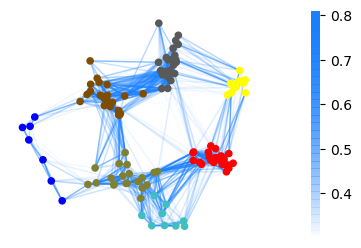

In [577]:
# VAMP 1 
fig = plt.figure(figsize=(4, 3), dpi=100)
gs = fig.add_gridspec(65, 100)
fullax = fig.add_subplot(gs[:, :])
fullax.axis('off')
ax = fig.add_subplot(gs[:, :80])

ax, pc = plot_dependency_graph(ax, graph_vamp1, pos_dicts[0], matched_assignments[0])

ax.axis('off')


cbar_ax = fig.add_subplot(gs[:, 97:])

cb = fig.colorbar(pc, cax=cbar_ax)
cb.outline.set_visible(False)

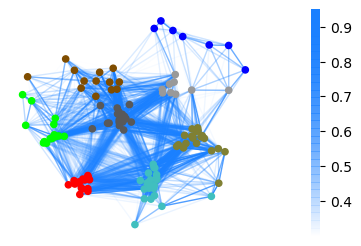

In [575]:
# VAMP 2
fig = plt.figure(figsize=(4, 3), dpi=100)
gs = fig.add_gridspec(65, 100)
fullax = fig.add_subplot(gs[:, :])
fullax.axis('off')
ax = fig.add_subplot(gs[:, :80])

ax, pc = plot_dependency_graph(ax, graph_vamp2, pos_dicts[1], matched_assignments[1])

ax.axis('off')


cbar_ax = fig.add_subplot(gs[:, 97:])

cb = fig.colorbar(pc, cax=cbar_ax)
cb.outline.set_visible(False)

In [ ]:
# Please note that results are subject to stochasticity from Fruchterman-Reingold and k-means algorithms.